In [23]:
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import time
from geosketch import gs
from sklearn.cluster import KMeans
import hashlib

In [43]:
import scanpy as sc
adata = sc.read_10x_mtx("filtered_matrices_mex/hg19/", var_names='gene_symbols', make_unique=True)
print(adata.shape)


(68579, 32738)


In [44]:
import scanpy as sc

# For demonstration, load a smaller dataset (3k PBMCs) from scanpy’s library
# adata = sc.datasets.pbmc3k()  # 3k PBMC subset
print(f"Loaded dataset with {adata.n_obs} cells and {adata.n_vars} genes.")

# Basic filtering (if using full 68k data, which is already filtered by Cell Ranger)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# (Optional) Filter out mitochondrial genes and cells with extreme counts if needed
# mito_genes = adata.var_names.str.startswith('MT-')
# adata.obs['pct_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100
# adata = adata[adata.obs['pct_mito'] < 10]  # for example, remove cells with >10% mitochondrial genes

# Normalize counts per cell to a total of 1e4 and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# Identify highly variable genes (HVGs) for dimensionality reduction
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)
adata = adata[:, adata.var['highly_variable']]


# Scale and perform PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
X_pca = adata.obsm['X_pca']

# Compute neighbors and clustering
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata, min_dist=0.5)
full_labels = adata.obs['leiden'].copy()
X_umap = adata.obsm['X_umap']

# Identify rare cluster
cluster_counts = adata.obs['leiden'].value_counts()
rare_cluster = cluster_counts.idxmin()
rare_count = cluster_counts.min()
print(f"Rare cluster is {rare_cluster} with {rare_count} cells.")

# Define sketch size
N = 1000

Loaded dataset with 68579 cells and 32738 genes.
Rare cluster is 28 with 193 cells.


In [45]:
methods = {}
subset_adatas = {}
times = {}
N = 1000  # desired sketch size (e.g., 1000 cells)

In [46]:
import numpy as np

start = time.time()
np.random.seed(42)
uniform_indices = np.random.choice(adata.n_obs, size=N, replace=False)
adata_uniform = adata[uniform_indices].copy()
end = time.time()
print(f"Uniformly sampled subset: {adata_uniform.n_obs} cells")
methods['Random'] = uniform_indices
subset_adatas['Random'] = adata[uniform_indices].copy()
times['Random'] = end - start
rare_labels = adata.obs['leiden'].iloc[uniform_indices]
rare_capture['Random'] = (rare_labels == rare_cluster).sum()

Uniformly sampled subset: 1000 cells


In [47]:
from geosketch import gs

X_pca = adata.obsm['X_pca']
N = 1000

start = time.time()
sketch_indices = gs(X_pca, N, replace=False)
adata_geosketch = adata[sketch_indices].copy()
end = time.time()
print(f"Geometric sketch subset: {adata_geosketch.n_obs} cells")
methods['Geometric'] = sketch_indices
subset_adatas['Geometric'] = adata[sketch_indices].copy()
times['Geometric'] = end - start
rare_labels = adata.obs['leiden'].iloc[sketch_indices]
rare_capture['Geometric'] = (rare_labels == rare_cluster).sum()

Geometric sketch subset: 1000 cells


In [48]:
start = time.time()

from sklearn.cluster import KMeans

X_pca = adata.obsm['X_pca']
kmeans = KMeans(n_clusters=N, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
centers = kmeans.cluster_centers_

# For each cluster, find the cell closest to the centroid
medoid_indices = []
for i in range(N):
    cluster_idx = np.where(cluster_labels == i)[0]
    if cluster_idx.size == 0:
        continue  # (should not happen if N ≤ number of cells)
    # distance from cluster centroid
    dist = np.sum((X_pca[cluster_idx] - centers[i])**2, axis=1)
    closest = cluster_idx[np.argmin(dist)]
    medoid_indices.append(closest)
medoid_indices = np.array(medoid_indices)
adata_kmedoids = adata[medoid_indices].copy()
print(f"K-Means medoids subset: {adata_kmedoids.n_obs} cells")


end = time.time()

methods['KMeans'] = medoid_indices
subset_adatas['KMeans'] = adata[medoid_indices].copy()
times['KMeans'] = end - start
rare_labels = adata.obs['leiden'].iloc[medoid_indices]
rare_capture['KMeans'] = (rare_labels == rare_cluster).sum()

K-Means medoids subset: 1000 cells


In [49]:
from sklearn.metrics.pairwise import rbf_kernel

def kernel_herding(X, N, gamma=1.0):
    """
    Kernel Herding: select N points from X using a greedy kernel herding strategy.
    
    Parameters:
        X (np.ndarray): Input data (e.g. PCA-reduced matrix).
        N (int): Number of points to sample.
        gamma (float): RBF kernel bandwidth.
    
    Returns:
        List[int]: Indices of selected points.
    """
    K = rbf_kernel(X, gamma=gamma)  # Precompute full kernel matrix
    n = K.shape[0]
    mu = K.mean(axis=0)  # Target distribution: mean embedding
    selected = []
    g = np.zeros(n)

    for _ in range(N):
        scores = mu - g / max(len(selected), 1)
        next_index = np.argmax(scores)
        selected.append(next_index)
        g += K[next_index]

    return selected

# 4. Kernel Herding (from scratch)
start = time.time()
kh_indices = kernel_herding(X_pca, N=1000, gamma=1.0)
end = time.time()

methods['Kernel Herding'] = kh_indices
subset_adatas['Kernel Herding'] = adata[kh_indices].copy()
times['Kernel Herding'] = end - start
rare_labels = adata.obs['leiden'].iloc[kh_indices]
rare_capture['Kernel Herding'] = (rare_labels == rare_cluster).sum()

In [50]:
# 5. Hashing-Based Sampling
start = time.time()
cell_ids = adata.obs_names
hash_values = [int(hashlib.md5(cell_id.encode()).hexdigest(), 16) for cell_id in cell_ids]
sorted_indices = np.argsort(hash_values)
hash_indices = sorted_indices[:N]
end = time.time()
methods['Hashing'] = hash_indices
subset_adatas['Hashing'] = adata[hash_indices].copy()
times['Hashing'] = end - start
rare_labels = adata.obs['leiden'].iloc[hash_indices]
rare_capture['Hashing'] = (rare_labels == rare_cluster).sum()

In [51]:
# 6. PCA-Weighted Sampling
start = time.time()
variances = np.var(X_pca, axis=1)
probabilities = variances / np.sum(variances)
pca_indices = np.random.choice(len(X_pca), size=N, replace=False, p=probabilities)
end = time.time()
methods['PCA-Weighted'] = pca_indices
subset_adatas['PCA-Weighted'] = adata[pca_indices].copy()
times['PCA-Weighted'] = end - start
rare_labels = adata.obs['leiden'].iloc[pca_indices]
rare_capture['PCA-Weighted'] = (rare_labels == rare_cluster).sum()

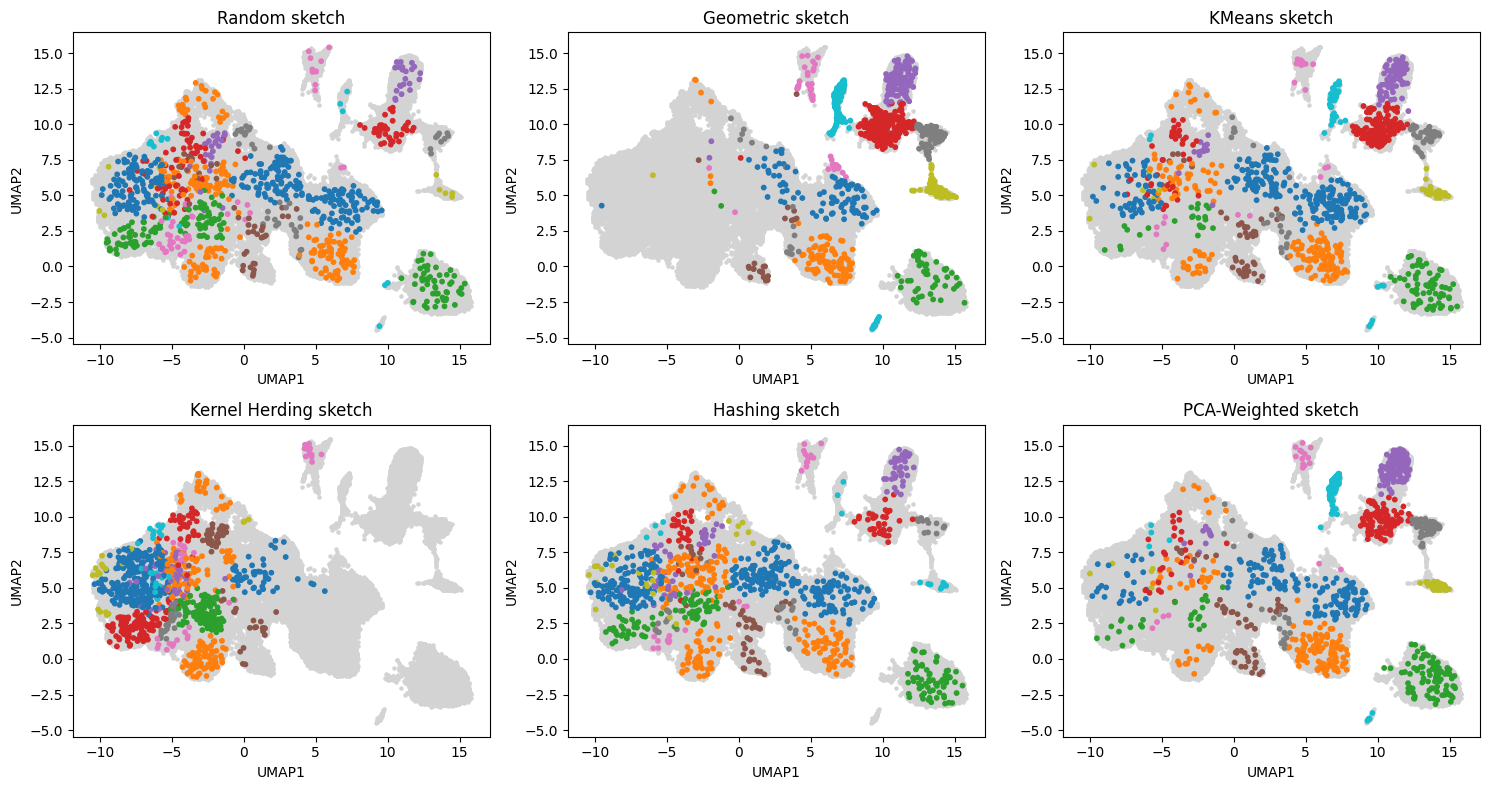

In [57]:
import matplotlib.pyplot as plt
import numpy as np

sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=1.0)

# Ensure UMAP is computed and clustering is available
sc.tl.umap(adata, min_dist=0.5)
full_labels = adata.obs['leiden'].copy()
X_umap = adata.obsm['X_umap']

# Determine the layout of subplots
n_methods = len(methods)
ncols = 3
nrows = int(np.ceil(n_methods / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for ax, (name, idx) in zip(axes, methods.items()):
    # Plot full dataset in gray
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c='lightgrey', s=5, label='Full data')
    # Plot sampled/sketched cells colored by cluster
    colors = full_labels.cat.codes.iloc[idx]  # index into cluster labels
    ax.scatter(X_umap[idx, 0], X_umap[idx, 1], c=colors, cmap='tab10', s=10, label=f'{name} subset')
    ax.set_title(f"{name} sketch")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

# Hide any extra axes if fewer than nrows * ncols
for i in range(len(methods), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('umap_sketches.png', dpi=600, bbox_inches='tight', format='png')
plt.show()


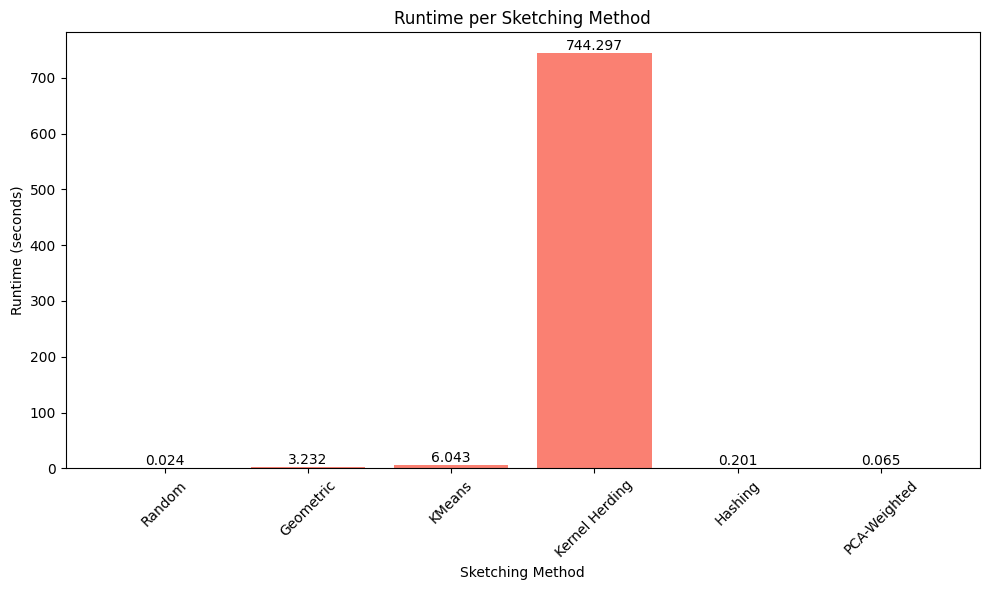

In [53]:
# Ensure `times` is a dictionary with method names as keys and runtime in seconds as values
method_names = list(times.keys())
runtime_values = [times[m] for m in method_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(method_names, runtime_values, color='salmon')
plt.xlabel('Sketching Method')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime per Sketching Method')

# Add labels with runtime values
for bar, runtime in zip(bars, runtime_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f"{runtime:.3f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



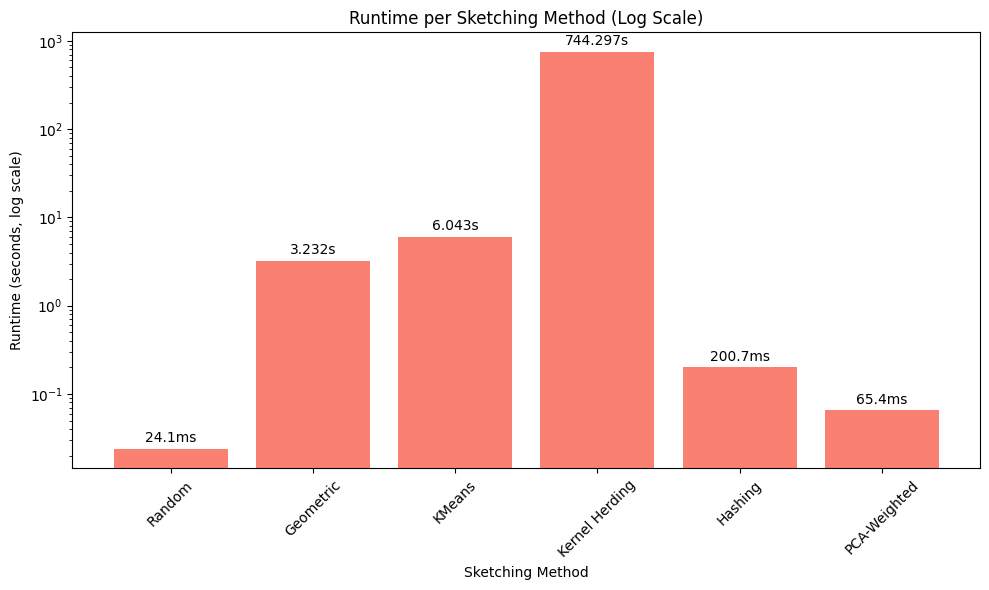

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Filter methods where runtime > 0 to avoid log(0)
runtime_data = {m: t for m, t in times.items() if t > 0}

# Extract names and values
method_names = list(runtime_data.keys())
runtime_values = [runtime_data[m] for m in method_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(method_names, runtime_values, color='salmon')
plt.yscale('log')  # This sets the y-axis to logarithmic scale
plt.xlabel('Sketching Method')
plt.ylabel('Runtime (seconds, log scale)')
plt.title('Runtime per Sketching Method (Log Scale)')

# Add text labels with raw times
for bar, rt in zip(bars, runtime_values):
    height = bar.get_height()
    label = f"{rt:.3f}s" if rt >= 1 else f"{rt*1000:.1f}ms"
    plt.text(bar.get_x() + bar.get_width() / 2.0, height * 1.1, label, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('time_comparison.png', dpi=600, bbox_inches='tight', format='png')
plt.show()



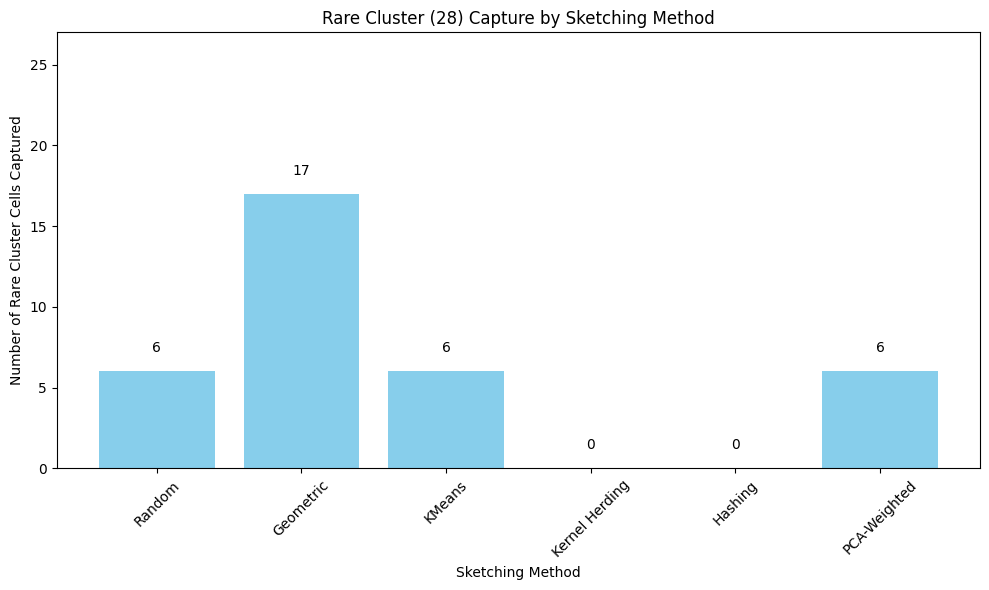

In [59]:
# Assuming 'rare_capture' is a dictionary with method names as keys and counts as values

# Extract method names and corresponding rare cluster counts
method_names = list(rare_capture.keys())
rare_counts = list(rare_capture.values())

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(method_names, rare_counts, color='skyblue')
plt.xlabel('Sketching Method')
plt.ylabel('Number of Rare Cluster Cells Captured')
plt.title(f'Rare Cluster ({rare_cluster}) Capture by Sketching Method')
plt.xticks(rotation=45)
plt.ylim(0, max(rare_counts) + 10)

# Annotate bars with counts
for bar, count in zip(bars, rare_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('rare_cluster_capture.png', dpi=600, bbox_inches='tight', format='png')
plt.show()


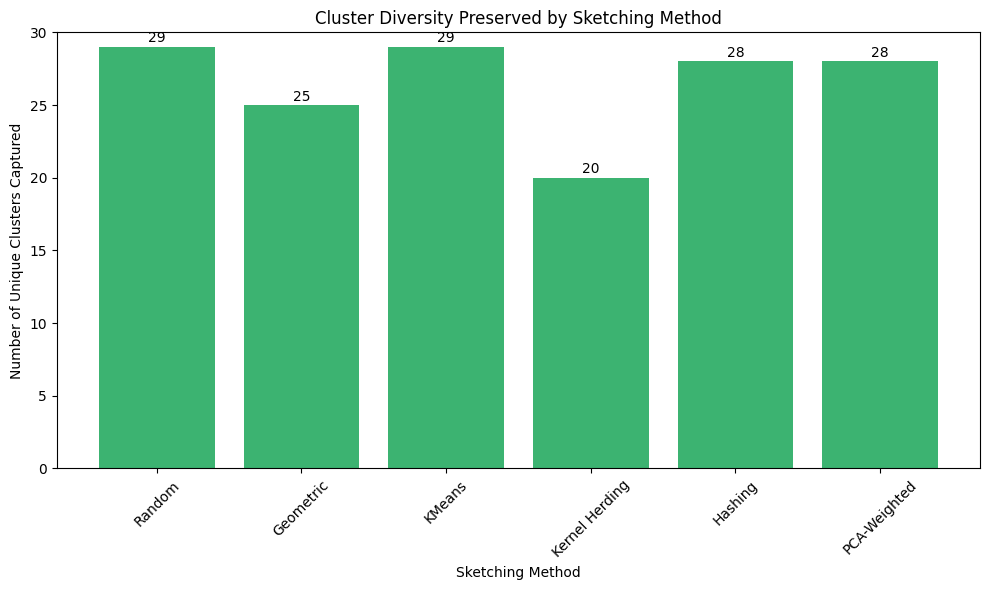

In [60]:
# Dictionary to hold the number of unique clusters per method
unique_clusters = {}

for method, indices in methods.items():
    cluster_labels = adata.obs['leiden'].iloc[indices]
    unique_clusters[method] = cluster_labels.nunique()

# Extract for plotting
method_names = list(unique_clusters.keys())
cluster_counts = list(unique_clusters.values())

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(method_names, cluster_counts, color='mediumseagreen')
plt.xlabel('Sketching Method')
plt.ylabel('Number of Unique Clusters Captured')
plt.title('Cluster Diversity Preserved by Sketching Method')
plt.xticks(rotation=45)
plt.ylim(0, max(cluster_counts) + 1)

# Annotate bars with counts
for bar, count in zip(bars, cluster_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('cluster_diversity.png', dpi=600, bbox_inches='tight', format='png')
plt.show()
